In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 1337

In [2]:
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [3]:
df_train["Class"].value_counts()

0    197982
1       383
Name: Class, dtype: int64

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_norm_heatmap(test, pred, color):
    f, axes = plt.subplots(ncols=2, figsize=(18, 5))
    print(classification_report(test, pred))
    sns.heatmap(confusion_matrix(test, pred), annot=True, fmt="g", ax=axes[0],
                cmap=sns.light_palette(color, as_cmap=True),
                xticklabels=["Not Fraud", "Fraud"],
                yticklabels=["Not Fraud", "Fraud"],
            )
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    axes[0].set_title("Numeric")

    sns.heatmap(confusion_matrix(test, pred, normalize="true"), annot=True, fmt="g", ax=axes[1],
                cmap=sns.light_palette(color, as_cmap=True),
                xticklabels=["Not Fraud", "Fraud"],
                yticklabels=["Not Fraud", "Fraud"],
            )
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")
    axes[1].set_title("Normalized")
    plt.show()

In [5]:
from sklearn.model_selection import train_test_split

df_features = df_train.drop("Class", axis=1)
df_target = df_train["Class"]

train_X, test_X, train_y, test_y = train_test_split(df_features, df_target,
            test_size=0.25, random_state=RANDOM_STATE, shuffle=True, stratify=df_target)

In [6]:
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count
from sklearn.model_selection import RandomizedSearchCV

print('catboost: %i GPU devices' % get_gpu_device_count())

cbc_params = {
    "learning_rate": [0.001, 0.01, 0.05, 0.1],
    "depth": range(6, 10),
    # "border_count": 128,
}

cbc = CatBoostClassifier(eval_metric='Recall',
                        random_seed=RANDOM_STATE,
                        metric_period=50,
                        iterations=200,
                        task_type="GPU",
                        devices="0:1")

final_clf = RandomizedSearchCV(cbc, cbc_params, cv=5)

catboost: 1 GPU devices


In [7]:
final_clf.fit(train_X, train_y, verbose=True)

0:	learn: 0.8086957	total: 21.3ms	remaining: 4.24s
50:	learn: 0.8869565	total: 972ms	remaining: 2.84s
100:	learn: 0.9260870	total: 1.92s	remaining: 1.89s
150:	learn: 0.9608696	total: 2.87s	remaining: 932ms
199:	learn: 0.9913043	total: 3.79s	remaining: 0us
0:	learn: 0.8034934	total: 18.3ms	remaining: 3.64s
50:	learn: 0.8689956	total: 972ms	remaining: 2.84s
100:	learn: 0.9301310	total: 1.92s	remaining: 1.88s
150:	learn: 0.9606987	total: 2.87s	remaining: 930ms
199:	learn: 0.9868996	total: 3.8s	remaining: 0us
0:	learn: 0.8078603	total: 19.3ms	remaining: 3.84s
50:	learn: 0.8777293	total: 959ms	remaining: 2.8s
100:	learn: 0.9301310	total: 1.91s	remaining: 1.87s
150:	learn: 0.9650655	total: 2.86s	remaining: 928ms
199:	learn: 0.9825328	total: 3.79s	remaining: 0us
0:	learn: 0.7695652	total: 20.4ms	remaining: 4.06s
50:	learn: 0.8739130	total: 962ms	remaining: 2.81s
100:	learn: 0.9086957	total: 1.91s	remaining: 1.87s
150:	learn: 0.9521739	total: 2.85s	remaining: 926ms
199:	learn: 0.9782609	total:

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001E88EC00400>,
                   param_distributions={'depth': range(6, 10),
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1]})

In [8]:
print(final_clf.best_params_)
print(final_clf.best_score_)

{'learning_rate': 0.1, 'depth': 6}
0.999569815680198


In [9]:
cbc_opt = CatBoostClassifier(eval_metric='Recall',
                        random_seed=RANDOM_STATE,
                        metric_period=50,
                        iterations=300,
                        task_type="GPU",
                        devices="0:1",
                        learning_rate=0.1,
                        depth=6)
cbc_opt.fit(train_X, train_y, verbose=True)

0:	learn: 0.7839721	total: 12.1ms	remaining: 3.61s
50:	learn: 0.8536585	total: 514ms	remaining: 2.51s
100:	learn: 0.8919861	total: 1.01s	remaining: 1.99s
150:	learn: 0.9163763	total: 1.52s	remaining: 1.5s
200:	learn: 0.9303136	total: 2.02s	remaining: 995ms
250:	learn: 0.9442509	total: 2.52s	remaining: 493ms
299:	learn: 0.9616725	total: 3.01s	remaining: 0us


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49496
           1       0.96      0.79      0.87        96

    accuracy                           1.00     49592
   macro avg       0.98      0.90      0.93     49592
weighted avg       1.00      1.00      1.00     49592



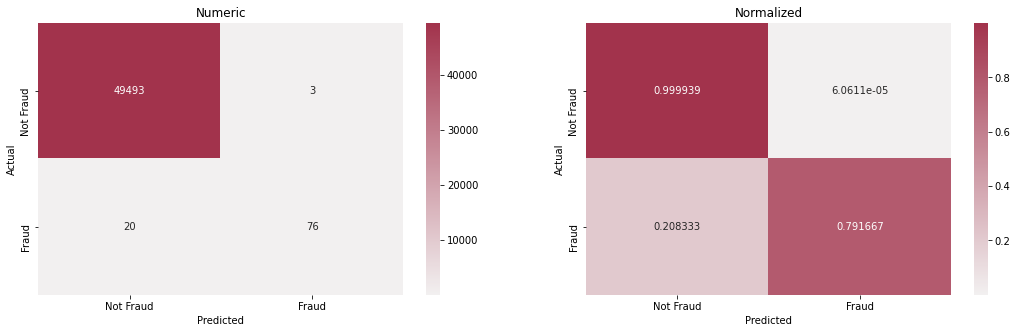

In [11]:
cbc_opt_pred = cbc_opt.predict(test_X)
plot_norm_heatmap(test_y, cbc_opt_pred, "#a2334c")

In [13]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_y, cbc_opt_pred)

0.8958030278541026

In [14]:
submission = cbc_opt.predict(df_test)

In [17]:
# sub_df = pd.DataFrame(data=submission.flatten())
# sub_df.columns = ["Class"]
sub_df = pd.DataFrame(data=df_test["ID"])
sub_df["Class"] = submission.flatten()

In [18]:
sub_df

,ID,Class
0,198366,0
1,198367,0
2,198368,0
3,198369,0
4,198370,0
...,...,...
86437,284803,0
86438,284804,0
86439,284805,0
86440,284806,0


In [19]:
# How many frauds were found
len(sub_df.loc[sub_df["Class"] == 1].values)

78

In [21]:
sub_df.to_csv("submission.csv", index=False)